In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

#____________________________________________________________

import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from sklearn.model_selection import train_test_split

#____________________________________________________________

from tqdm.notebook import tqdm
from termcolor import colored
import albumentations as A
from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)
directory = "/content/drive/MyDrive/chestxraydataset"

#____________________________________________________________

print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...


In [ ]:
train_df = glob.glob("/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/**/*.jpeg")
test_df = glob.glob("/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/test/**/*.jpeg")
# validation_df = glob.glob("/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/test/**/*.jpeg")

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

The datasets were succesfully loaded...


In [ ]:
train_df[:5], test_df[:5]

(['/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0006-0001.jpeg',
  '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0001-0001.jpeg',
  '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0003-0001.jpeg',
  '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0005-0001.jpeg',
  '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0050-0001.jpeg'],
 ['/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg',
  '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig5-day0.jpeg',
  '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g09c-Fig9c-day27.jpeg',
  '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg',


In [ ]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
# print("There is {} images in the validation dataset".format(len(validation_df)))

In [ ]:
datasets, pneumonia_lung, normal_lung = ["train", "test", "val"], [], []

for i in datasets:
    path = os.path.join(directory, i)
    normal = glob.glob(os.path.join(path, "/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))

The number of pneumonia images is 123
The number of non-pneumonia images is 222


In [ ]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)
images = normal_lung[:50] + pneumonia_lung[:50]
images[:10]

['/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0011-0001-0002.jpeg',
 '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0093-0001.jpeg',
 '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0073-0001.jpeg',
 '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0009-0001.jpeg',
 '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0033-0001-0001.jpeg',
 '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0107-0001.jpeg',
 '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0046-0001.jpeg',
 '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0071-0001.jpeg',
 '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0041-0001.jpeg',
 '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0006-0001.jpeg']

NORMAL


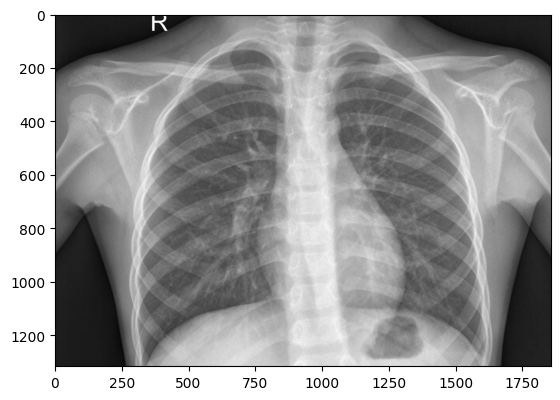

In [ ]:
normal_lung_image = load_img("/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/NORMAL/IM-0001-0001.jpeg")
print("NORMAL")
plt.imshow(normal_lung_image)
plt.show()

PNEUMONIA


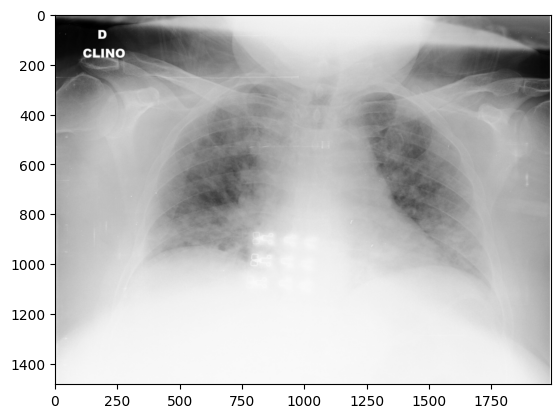

In [ ]:
normal_lung_image = load_img("/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/PNEUMONIA/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg")
print("PNEUMONIA")
plt.imshow(normal_lung_image)
plt.show()

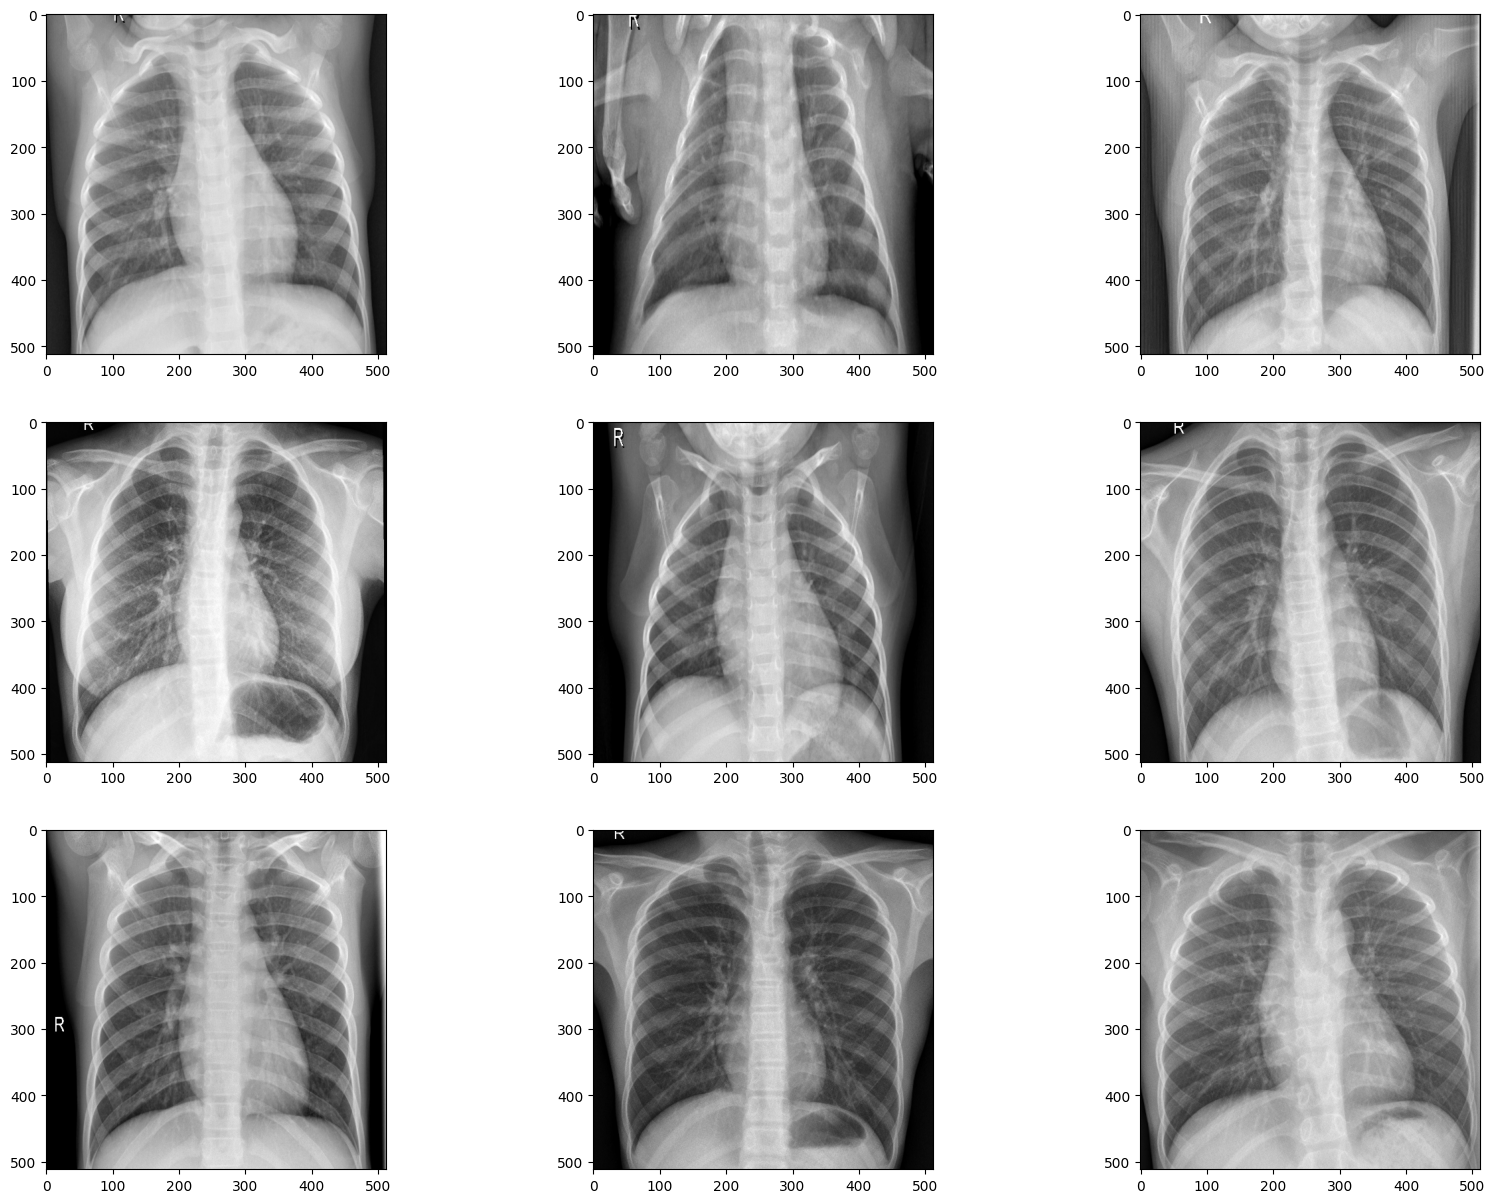

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

Image Erosion

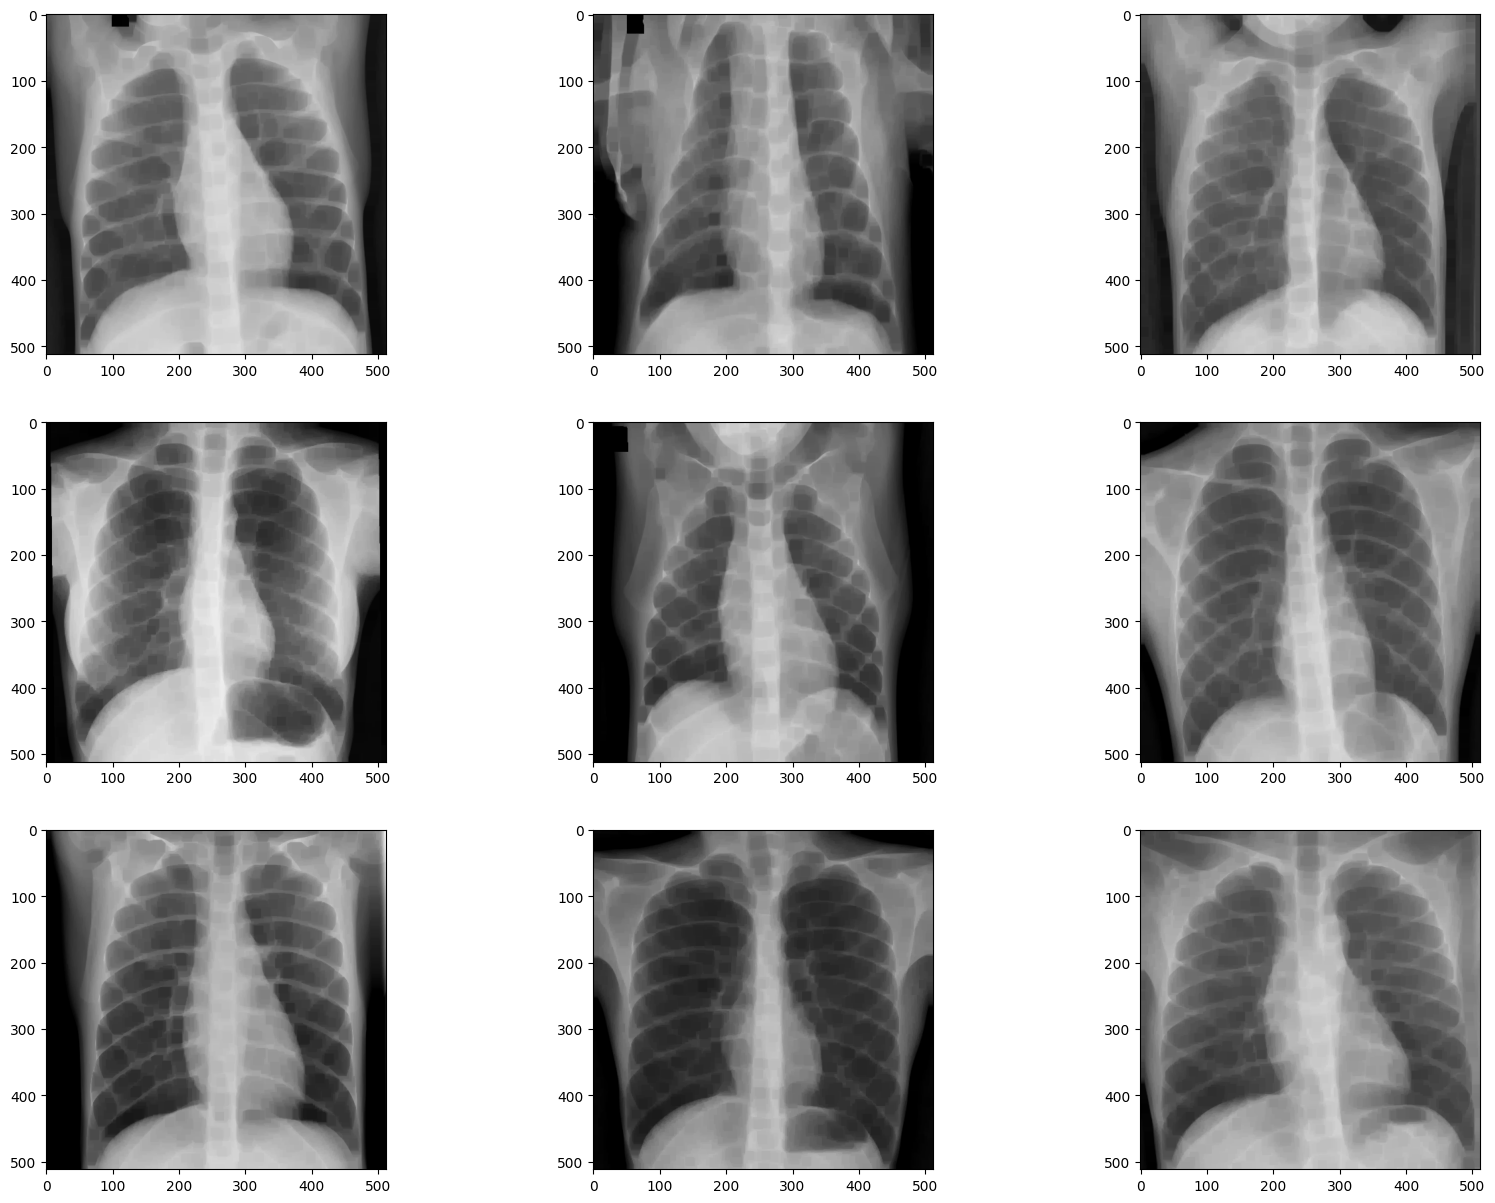

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_erosion)

Image Dilation

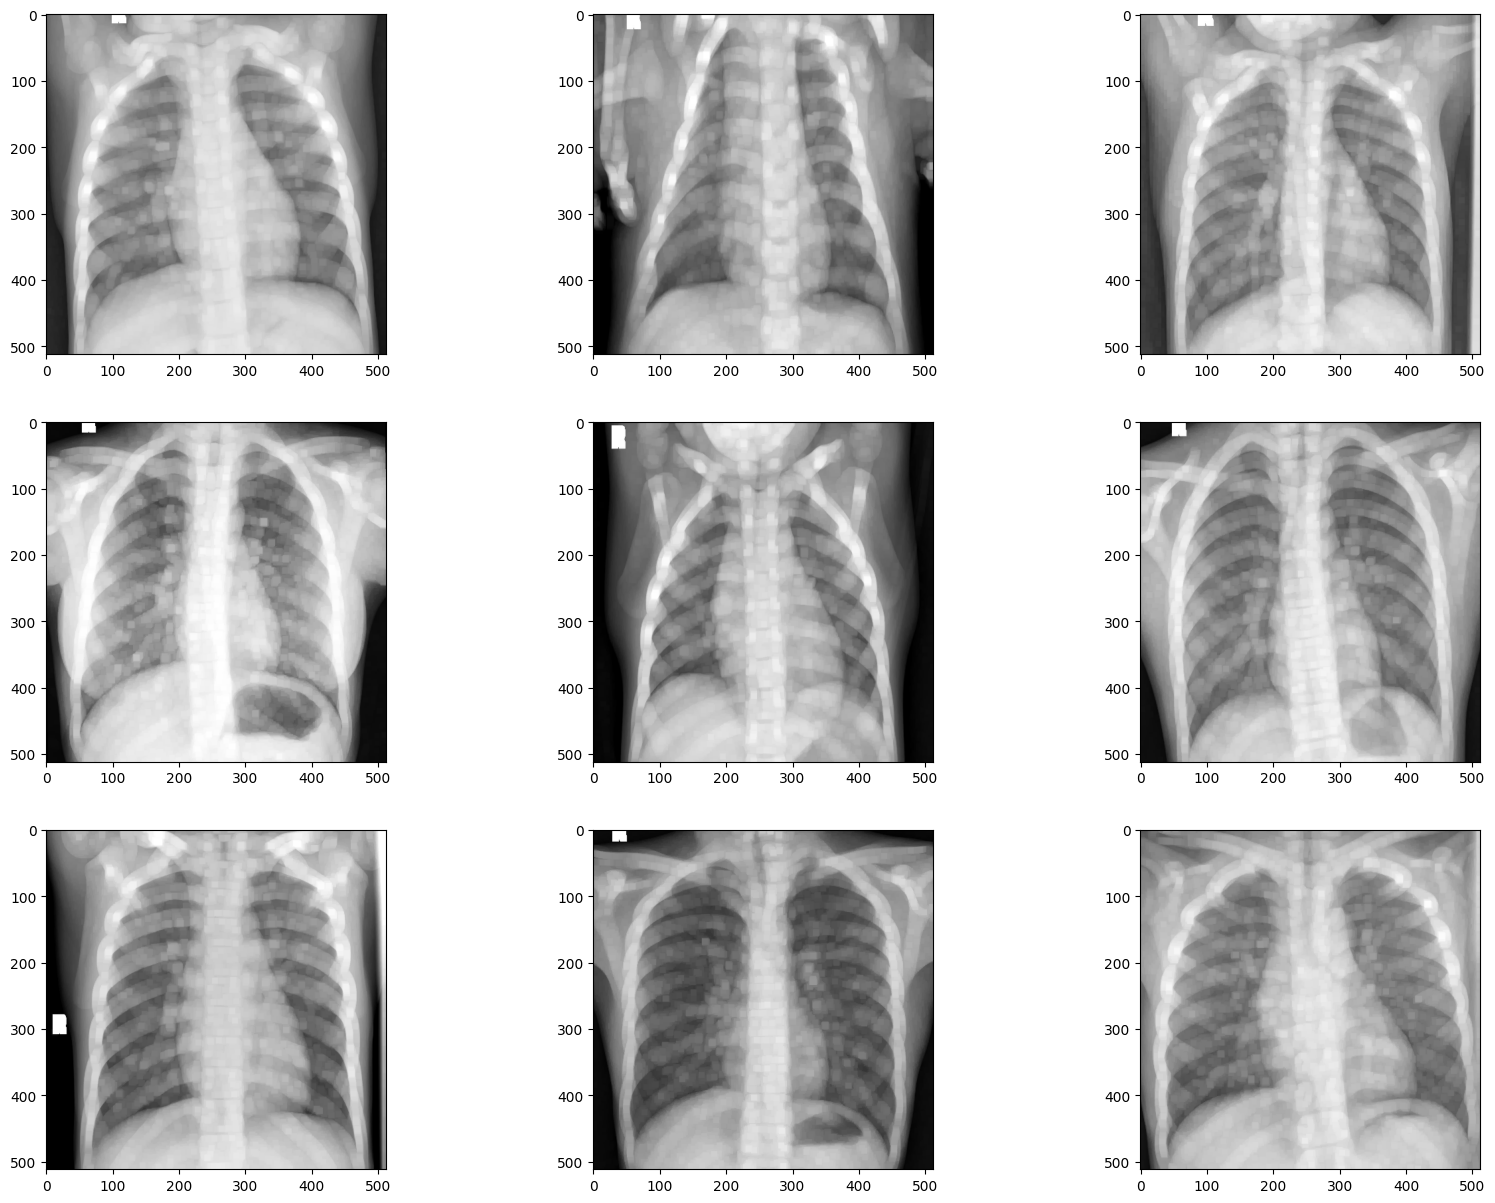

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_dilation = cv2.dilate(img, kernel, iterations = 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_dilation)

Convert the images to greyscale and then apply Gaussian blur to them

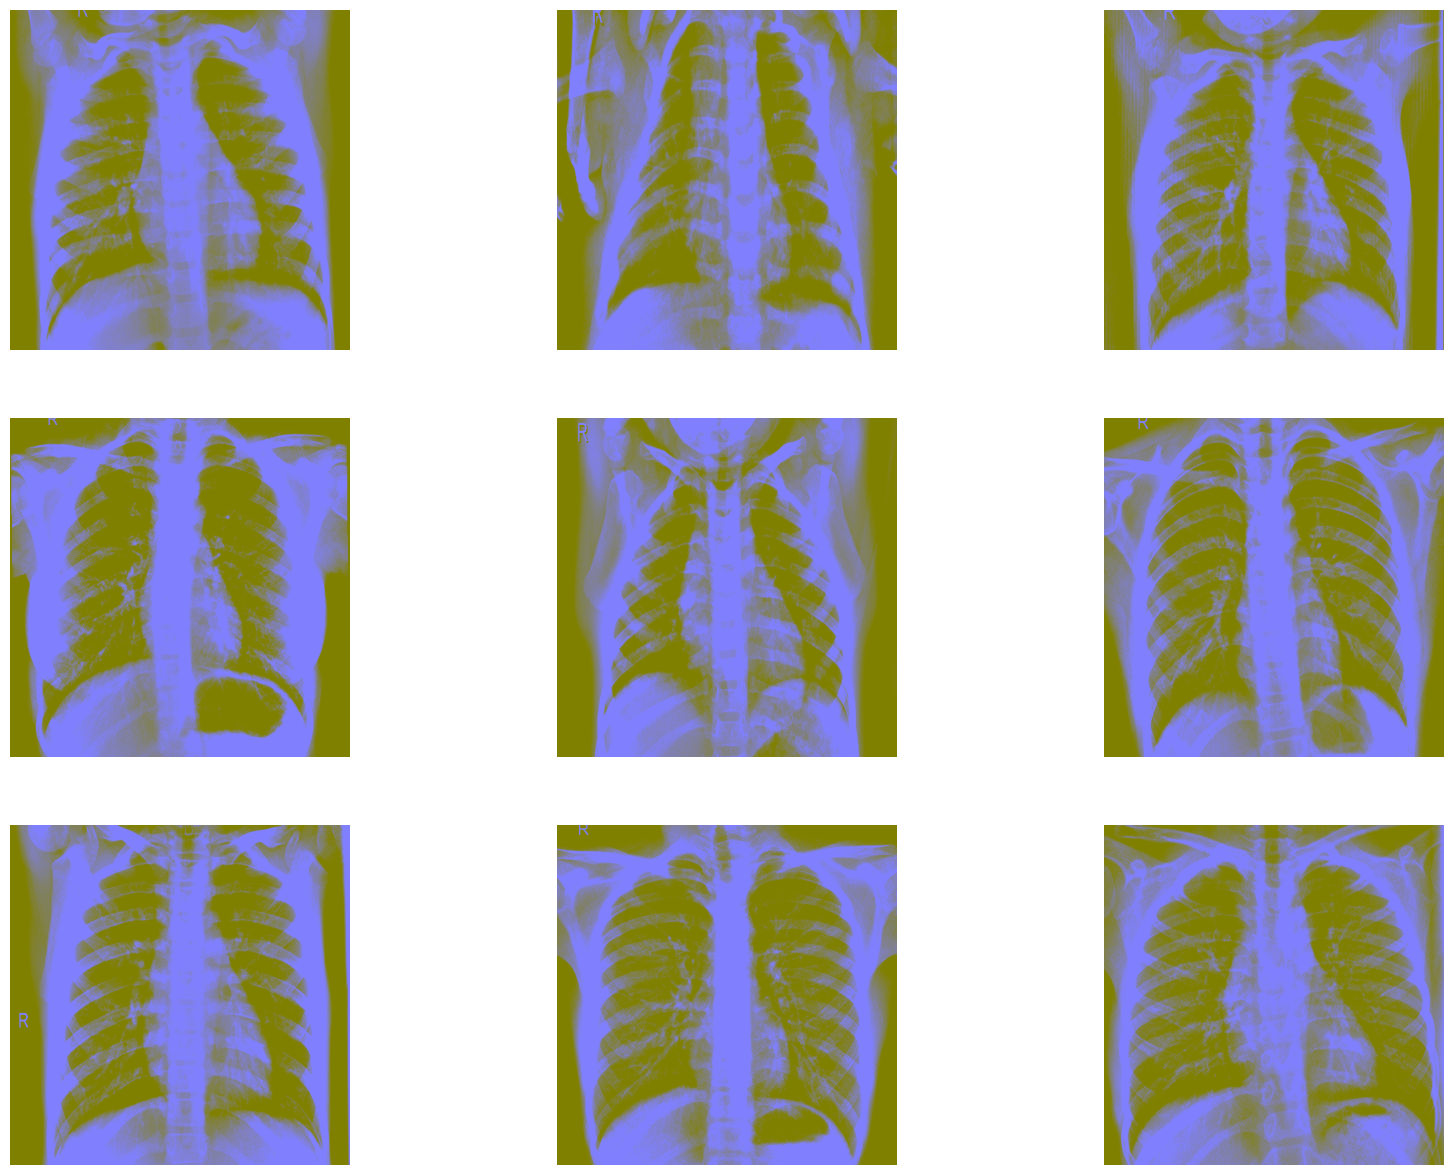

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

Canny edge detection

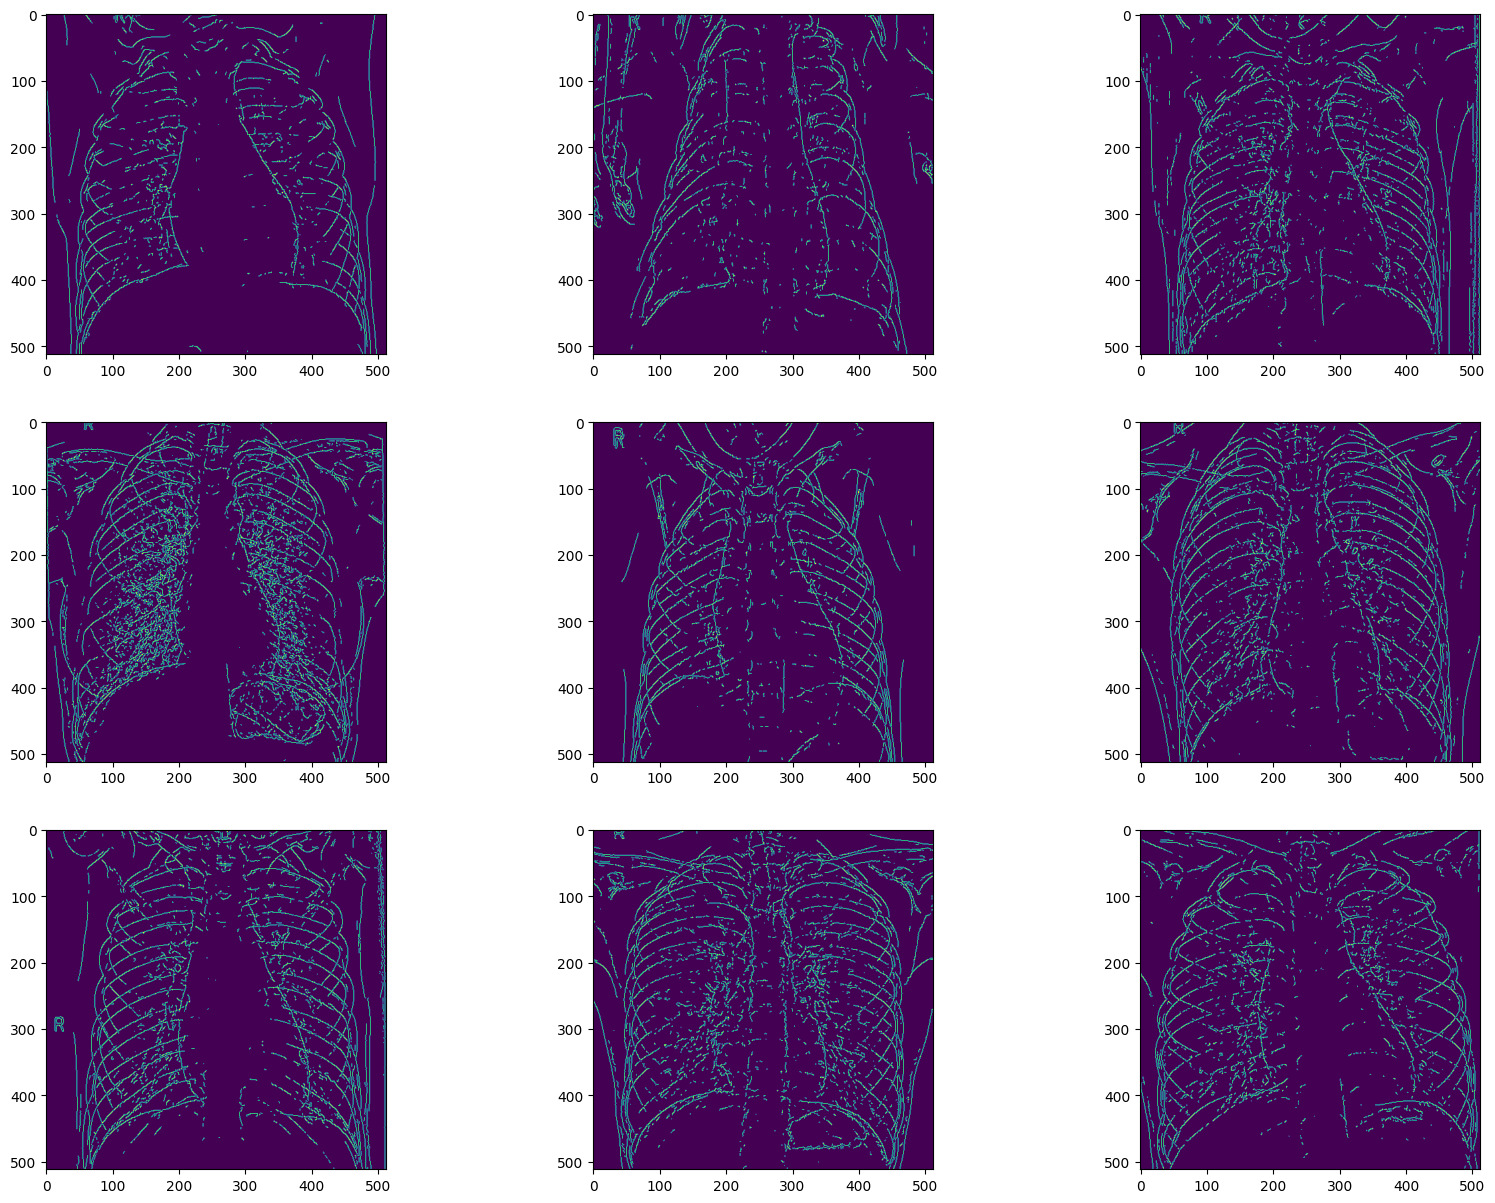

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(detected_edges)